In [1]:
# 데이터 증강(Data Argumentation)
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
        rescale=1./255,          # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,       # 40도까지 회전
        width_shift_range=0.2,   # 20%까지 좌우 이동
        height_shift_range=0.2,  # 20%까지 상하 이동
        shear_range=0.2,         # 20%까지 기울임
        zoom_range=0.2,          # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )


In [2]:
# 학습 데이터 이미지 로드 
train = img_gen.flow_from_directory(
    'test_set/test_set',     # 이미지 디렉토리
    target_size=(100, 100), # 변환할 크기는 가로 100, 세로 100
    color_mode='rgb',       # 컬러는 rgb, 흑백은 grayscale. 생략하면 컬러로 처리한다
    class_mode='binary'     # 고양이 vs. 개로 binary 분류
)    


Found 2023 images belonging to 2 classes.


In [3]:
# 검증 데이터 이미지 로드 
valid = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    'training_set/training_set',
    target_size=(100, 100),
    class_mode='binary',
    shuffle=False)


Found 8005 images belonging to 2 classes.


In [4]:
# - 로지스틱 회귀 모형과 동일한 케라스 모형 만들기
from keras import Sequential
from keras.layers import Dense, Flatten

model = Sequential()


In [5]:
# 입력 , 출력 레이어 추가 
model.add(Flatten(input_shape=(100, 100, 3)))  # 이미지 크기 (100.100)  3 (RGB)
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 1)                 30001     
                                                                 
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________


In [6]:
#모형 설정
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.001))


C:\Users\user\AppData\Local\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#모델 학습 
model.fit_generator(train, validation_data=valid, epochs=30)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14204\4215728384.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train, validation_data=valid, epochs=30)


Epoch 1/30
64/64 [==============================] - 52s 821ms/step - loss: 1.2081 - accuracy: 0.5146 - val_loss: 0.7015 - val_accuracy: 0.5600
Epoch 2/30
64/64 [==============================] - 14s 219ms/step - loss: 0.7645 - accuracy: 0.5175 - val_loss: 1.0479 - val_accuracy: 0.5048
Epoch 3/30
64/64 [==============================] - 14s 217ms/step - loss: 0.8346 - accuracy: 0.5255 - val_loss: 0.8308 - val_accuracy: 0.5193
Epoch 4/30
64/64 [==============================] - 14s 219ms/step - loss: 0.9689 - accuracy: 0.5304 - val_loss: 1.0557 - val_accuracy: 0.5068
Epoch 5/30
64/64 [==============================] - 14s 219ms/step - loss: 0.8714 - accuracy: 0.5334 - val_loss: 0.9588 - val_accuracy: 0.5123
Epoch 6/30
64/64 [==============================] - 14s 219ms/step - loss: 0.9137 - accuracy: 0.5230 - val_loss: 0.8846 - val_accuracy: 0.5270
Epoch 7/30
64/64 [==============================] - 14s 221ms/step - loss: 0.8330 - accuracy: 0.5344 - val_loss: 0.8821 - val_accuracy: 0.5118

In [ ]:
#3. LIME으로 설명
#LIME으로 이미지에 대한 설명을 만든다. 먼저 이미지를 (100, 100) 사이즈로 불러온다.
#   ----  Version 업그레이드에 따른 변경 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 로드
img = tf.keras.preprocessing.image.load_img('test_set/test_set/cats/cat.4998.jpg', target_size=(100, 100))
img


In [35]:
# 이미지를 넘파이 어레이로 바꾸고 255로 나누어 픽셀값을 0~1 범위로 바꾼다.
import numpy
img_array = numpy.array(img) / 255
img_array.shape


(100, 100, 3)

In [36]:
#이 이미지는 강아지일 확률이 매우 낮으므로 고양이일 확률이 높다.
#하위 폴더의 알파벳 순(디폴트) {'cats': 0, 'dogs': 1}

model.predict(numpy.array([img_array]))


1/1 [==============================] - 0s 61ms/step


array([[0.4762861]], dtype=float32)

In [38]:
# 검증(steps -> 샘플 테스트 수 지정)
scores = model.evaluate_generator(valid, steps=None)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52528\2450581391.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(valid, steps=None)


accuracy: 57.38%


In [39]:
#LIME을 이용해서 이 이미지가 고양이로 분류되는 이유를 알아보자.

from lime.lime_image import LimeImageExplainer
explainer = LimeImageExplainer()


In [40]:
# 이 이미지의 일부를 지운 30개의 샘플을 만들어서 고양이로 분류되는 이유를 찾아본다.
explanation = explainer.explain_instance(img_array, model.predict, num_samples=30)


  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


In [41]:
#고양이로 인식하게 만드는 부분만 보이도록 마스크를 만든다.
temp, mask = explanation.get_image_and_mask(label=0, hide_rest=True)


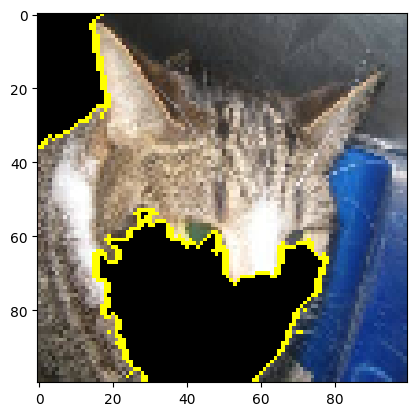

In [42]:
#마스크를 시각화한다.
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(mark_boundaries(temp, mask))
